In [ ]:
!pip install ultralytics opencv-python-headless matplotlib easyocr

In [ ]:
!pip install pytesseract
!pip install imgaug

In [4]:
import os
os.environ['LC_ALL'] = 'C.UTF-8'
os.environ['LANG'] = 'C.UTF-8'


In [ ]:
!apt-get install tesseract-ocr
!apt-get install tesseract-ocr-kor


In [6]:
import json
import os
import shutil
import requests
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
import pytesseract

In [10]:
model = YOLO('/content/drive/MyDrive/runs/detect/train_v8n (1)/weights/best.pt')

# Step 7: Use the trained model to run detection on sample images
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'  # Adjust path as necessary


0: 640x640 1 Name, 1 DOB, 1 Gender, 1 AadhaarNumber, 217.5ms
1: 640x640 1 Name, 1 DOB, 1 IDNumber, 1 Address, 217.5ms
2: 640x640 1 Name, 1 DOB, 1 Gender, 1 AadhaarNumber, 1 IssueDate, 217.5ms
3: 640x640 1 Name, 1 RegistrationNumber, 1 CountryName, 1 IssueDate, 217.5ms
Speed: 4.6ms preprocess, 217.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
Name: Mildred Baker
AadhaarNumber: 7367 4593 5329
DOB: + 02/02/2003
Gender: Female


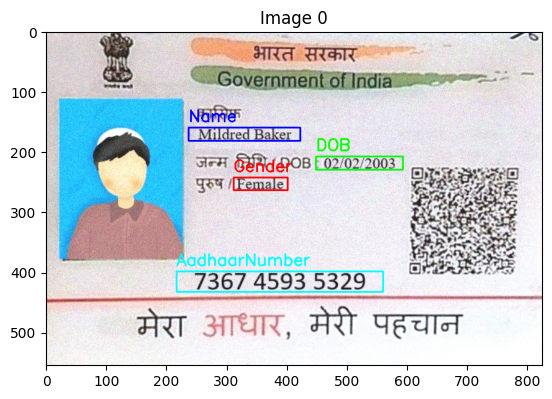

Name: 
IDNumber: 573590-1608631
Address: 울산광역시 관악구 논현4길
DOB: 1975.08.08


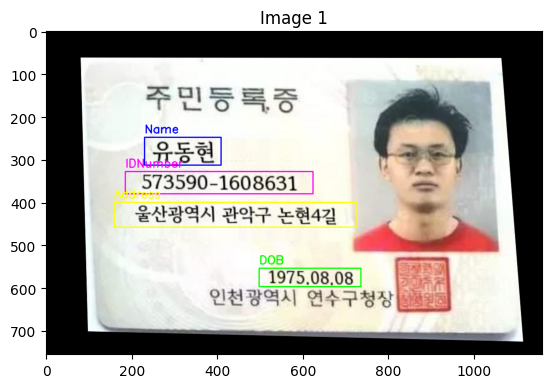

IssueDate: P
DOB: - 13/03/1961
AadhaarNumber: = 6378 0866 3459
Name: Alexander Quigg [
Gender: /Female


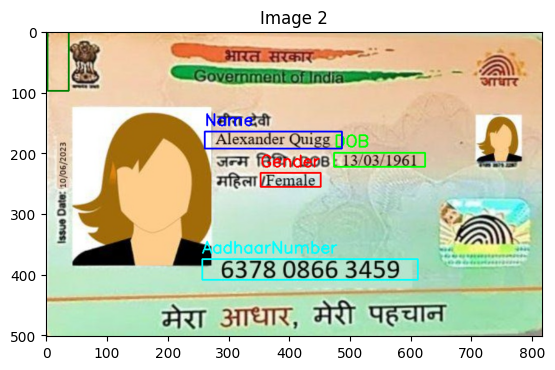

RegistrationNumber: 014262-9822764
IssueDate: 
CountryName: VIETNAM |
Name: JOHN LAWRENCE


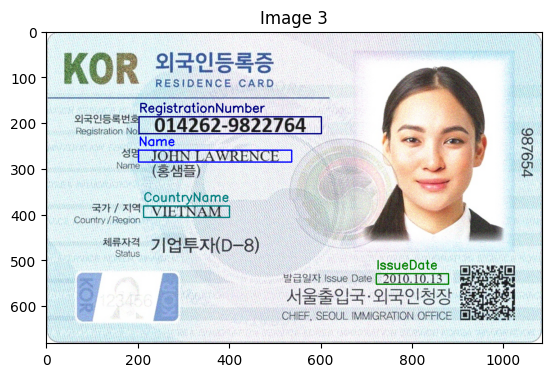

In [12]:
import random
import pytesseract
import cv2
import matplotlib.pyplot as plt

# Step 7: Use the trained model to run detection on sample images

# List of sample images
image_paths = [
    '/content/drive/MyDrive/dataset/images/val/india1_479.jpg',
    '/content/drive/MyDrive/dataset/images/val/korean_id1_482.jpg',
    '/content/drive/MyDrive/dataset/images/val/india2_411.jpg',
    '/content/drive/MyDrive/dataset/images/val/korean_id2_482.jpg'
]

# Run detection on sample images
results = model(image_paths)

# Define margin percentage (e.g., 8%)
margin_percent = 0.1

# List of colors for different fields
colors = [
    (255, 0, 0),  # Red
    (0, 255, 0),  # Green
    (0, 0, 255),  # Blue
    (255, 255, 0),  # Cyan
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Yellow
    (128, 0, 0),  # Maroon
    (128, 128, 0),  # Olive
    (0, 128, 0),  # Dark Green
    (0, 0, 128),  # Navy
    (128, 0, 128),  # Purple
    (0, 128, 128)  # Teal
]

for i, result in enumerate(results):
    # Load the original image
    image = cv2.imread(image_paths[i])

    # Extract the Boxes object
    boxes_obj = result.boxes

    if boxes_obj is not None:
        # Extract bounding boxes and class IDs
        boxes = boxes_obj.xyxy.cpu().numpy()  # Bounding box coordinates
        class_ids = boxes_obj.cls.cpu().numpy().astype(int)  # Class IDs
        labels = [result.names[int(cls)] for cls in class_ids]

        # Extend colors if there are more labels than colors
        if len(labels) > len(colors):
            for _ in range(len(labels) - len(colors)):
                colors.append(tuple(random.randint(0, 255) for _ in range(3)))

        # Draw bounding boxes
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box[:4]

            # Calculate margin
            margin_x = (x2 - x1) * margin_percent
            margin_y = (y2 - y1) * margin_percent

            # Expand the bounding box by the margin
            x1 = max(0, x1 - margin_x)
            y1 = max(0, y1 - margin_y)
            x2 = min(image.shape[1], x2 + margin_x)
            y2 = min(image.shape[0], y2 + margin_y)

            # Select color for the current label
            color = colors[class_ids[labels.index(label)] % len(colors)]

            # Draw the expanded bounding box
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            cv2.putText(image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

            # Crop the detected field with margin
            cropped_img = image[int(y1):int(y2), int(x1):int(x2)]

            if label in ["Name", "Address"]:
                # Use Tesseract OCR to read text from the cropped field
                text_eng = pytesseract.image_to_string(cropped_img, config='--psm 6', lang='eng').strip()
                text_kor = pytesseract.image_to_string(cropped_img, config='--psm 6', lang='kor').strip()

                # Determine which language the text is in based on 50% character match
                korean_chars = sum(1 for char in text_kor if '\uac00' <= char <= '\ud7a3')
                text = text_kor if(len(text_kor)>0 and korean_chars / len(text_kor) >= 0.5) else text_eng
            else:
                text = pytesseract.image_to_string(cropped_img, config='--psm 6', lang='eng').strip()

            # Print the extracted text
            print(f'{label}: {text}')

    else:
        print(f"No detections in image {i}")

    # Display the image with bounding boxes
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i}")
    plt.show()
